# driver_DD_NMROM
Driver to implement and test NM ROM on the 2D Burgers Equation.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib import cm
import matplotlib.colors as colors
import scipy.sparse as sp
import scipy.linalg as la
from time import time
import dill as pickle
import os
from utils.Burgers2D_probgen import Burgers2D
from utils.domain_decomposition import DD_model
from utils.LS_ROM import compute_bases_from_svd, DD_LS_ROM
from utils.NM_ROM import DD_NM_ROM, separate_snapshots, compute_residual_bases, RBFmdl, get_net_np_params, sp_diag
from scipy.interpolate import RBFInterpolator

/usr/workspace/diaz64/anaconda/envs/opence-1.7.2-cuda-11.4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = './data/'
fig_dir0 = './figures/'
for d in [data_dir, fig_dir0]:
    if not os.path.exists(d): os.mkdir(d)
plt.rc('font', size=20)
plt.rcParams['text.usetex'] = True

## Set model parameters

In [3]:
# define constant parameters for PDE
nx, ny  = 480, 24
x_lim   = [-1.0, 1.0]
y_lim   = [0.0, 0.05]

na1, nlam = 80, 80
a1_lim  = [1.0, 10000.0]
lam_lim = [5.0, 25.0]

a1, lam = 7692.5384, 21.9230
viscosity = 1e-1

print(f'a1, lam = {a1, lam}')

# number of subdomains in x and y directions for DD model
n_sub_x = 2
n_sub_y = 1

scaling = -1 # scaling factor for residual. -1 uses hx*hy

n_sub   = n_sub_x*n_sub_y
fig_dir1 = fig_dir0 + f'nx_{nx}_ny_{ny}_mu_{viscosity}_{n_sub_x}x_by_{n_sub_y}y/'
fig_dir  = fig_dir1 + f'a1_{a1}_lam_{lam}/'
svd_dir  = data_dir + f'nx_{nx}_ny_{ny}_mu_{viscosity}_{n_sub_x}x_by_{n_sub_y}y/'
nm_figs  = fig_dir + 'nmrom/'
for d in [fig_dir1, fig_dir, nm_figs]:
    if not os.path.exists(d):
        os.mkdir(d)
if not os.path.exists(svd_dir): print('Error: Must run LS-ROM notebook before proceeding.')

a1, lam = (7692.5384, 21.923)


In [4]:
# load snapshot and residual data
file = f'./data/residual_nx_{nx}_ny_{ny}_mu_{viscosity}_Nsamples_{400}.p'
data = pickle.load(open(file, 'rb'))
Mu = data['parameters']
snapshots = data['snapshots']
residuals = data['residuals']

## Solve DD FOM

In [5]:
# compute FOM for given a1 and lambda
def u_exact(x, y):
    phi = a1 + a1*x + (np.exp(lam*(x-1.0)) + np.exp(-lam*(x - 1.0)))*np.cos(lam*y)
    val = -2.0*viscosity*(a1 + lam*(np.exp(lam*(x-1.0)) \
          - np.exp(-lam*(x - 1.0)))*np.cos(lam*y))/phi
    return val
def v_exact(x, y):
    phi = a1 + a1*x + (np.exp(lam*(x-1.0)) + np.exp(-lam*(x - 1.0)))*np.cos(lam*y)
    val =  2.0*viscosity*(lam*(np.exp(lam*(x-1.0)) \
           + np.exp(-lam*(x - 1.0)))*np.sin(lam*y))/phi
    return val

# generate Burgers FOM on full domain
fom = Burgers2D(nx, ny, x_lim, y_lim, viscosity, u_exact, v_exact)
print('Solving full domain model:')
u_fom, v_fom, res_hist = fom.solve(np.zeros(fom.nxy), np.zeros(fom.nxy), tol=1e-8, print_hist=False)
sol_fd = np.concatenate([u_fom, v_fom])

# compute Burgers DD FOM
ddmdl = DD_model(fom, n_sub_x, n_sub_y, scaling=scaling)
ndof_fom = 2*np.sum([s.n_interior+s.n_interface for s in ddmdl.subdomain]) \
            + ddmdl.subdomain[0].constraint_mat.shape[0]
w0 = np.zeros(ndof_fom)
print('\nSolving DD model:')
print(f'FOM DoF = {ndof_fom-ddmdl.n_constraints}')
u_dd_fom, v_dd_fom, u_intr, v_intr, u_intf, v_intf, lam_fom, fom_time, itr = ddmdl.solve(w0, tol=1e-9, 
                                                                           maxit=15,
                                                                           print_hist=True)
sol_dd_fom = np.concatenate([u_dd_fom, v_dd_fom])

dd_fom_rel_err = np.linalg.norm(sol_dd_fom-sol_fd)/np.linalg.norm(sol_fd)
print(f'\nDD-FOM relative error = {dd_fom_rel_err:1.4e}') 

Solving full domain model:
Starting Newton solver...
Newton solver terminated after 14 iterations with residual 5.9127e-09.

Solving DD model:
FOM DoF = 23136
Starting Newton solver...
iter       Stepsize       Residual
   0       0.000e+00      2.341e+06
   1       1.000e+00      7.364e+04
   2       1.000e+00      1.058e+04
   3       1.000e+00      1.096e+03
   4       1.000e+00      9.303e+01
   5       1.000e+00      7.897e+00
   6       1.000e+00      6.731e-01
   7       1.000e+00      5.762e-02
   8       1.000e+00      4.959e-03
   9       1.000e+00      4.295e-04
  10       1.000e+00      3.748e-05
  11       1.000e+00      3.299e-06
  12       1.000e+00      2.932e-07
  13       1.000e+00      2.638e-08
  14       1.000e+00      2.944e-09
  15       1.000e+00      1.742e-09
Newton failed to converge in 15 iterations.
Newton solver terminated after 15 iterations with residual 1.7418e-09.

DD-FOM relative error = 8.5641e-16


In [6]:
# restrict snapshots to interior and interface subdomains
interior, interface = separate_snapshots(ddmdl, snapshots)

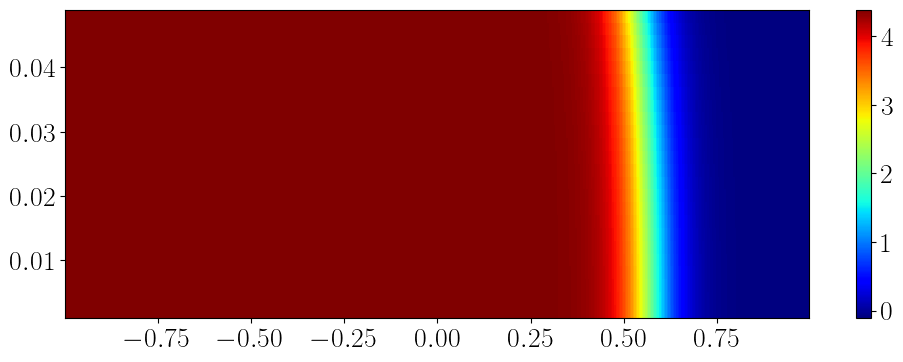

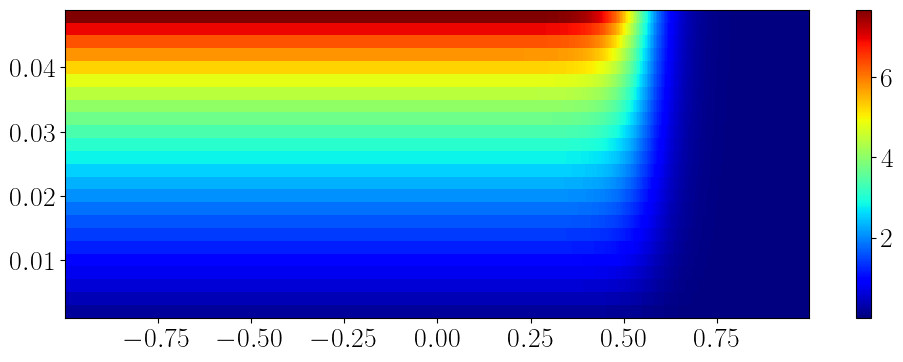

In [7]:
# plot DD FOM u and v
x = np.linspace(x_lim[0], x_lim[1], nx+2)[1:-1]
y = np.linspace(y_lim[0], y_lim[1], ny+2)[1:-1]
X, Y = np.meshgrid(x, y)
U_fom = u_dd_fom.reshape(ny, nx)
V_fom = v_dd_fom.reshape(ny, nx)

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, U_fom, cmap=cm.jet, shading='auto', vmin=u_fom.min(), vmax=u_fom.max())
# plt.xlabel('$x$')
# plt.ylabel('$y$')
cb = plt.colorbar()#label='$u(x, y)$')
file = fig_dir+'u_fom.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, V_fom, cmap=cm.jet, shading='auto', vmin=v_fom.min(), vmax=v_fom.max())
# plt.xlabel('$x$')
# plt.ylabel('$y$')
cb = plt.colorbar()#label='$v(x, y)$')
file = fig_dir+'v_fom.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Solve DD NM-ROM

In [8]:
ec     = 1e-10          # energy criteria for number of interior and interface basis vectors
nbasis = -1             # number of residual basis vectors. set to -1 to use energy criteria

# load SVD data
print('Loading residual SVD data...')
res_dict  = pickle.load(open(svd_dir+'res_svd.p', 'rb'))
print('Data loaded!')

# compute bases
print('Computing residual bases...')
residual_bases = compute_bases_from_svd(res_dict, ec=ec, nbasis=nbasis)
print('Bases computed!')

for i in range(n_sub):
    print(f'residual_bases[{i}]={residual_bases[i].shape}')

Loading residual SVD data...
Data loaded!
Computing residual bases...
Bases computed!
residual_bases[0]=(11520, 27)
residual_bases[1]=(11520, 72)


In [9]:
# port ROM sizes
pld        = 2
port_size  = [min(len(ddmdl.port_dict[p]-1), pld) for p in ddmdl.ports]
port_rnnz  = 3*np.ones(len(ddmdl.ports), dtype=int) 
port_shift = 3*np.ones(len(ddmdl.ports), dtype=int) 
port_act_type = 'Sigmoid' #'Swish'

Ntotal = 6400 if nx in [240, 480] else 4200
net_folder0 = f'./trained_nets/nx_{nx}_ny_{ny}_mu_{viscosity}_{n_sub_x}x_by_{n_sub_y}y/'
port_net_list = [net_folder0+\
                 f'port_{i+1}of{len(ddmdl.ports)}/'+\
                 f'ld_{port_size[i]}_rnnz_{port_rnnz[i]}_rshift_{port_shift[i]}_'+\
                 f'{port_act_type}_batch_32_AbsMSEloss_{Ntotal}snaps.p' \
                  for i in range(len(ddmdl.ports))] 

# interior and interface state ROM sizes
intr_size = 6
intf_size = 3
intr_rnnz = 5
intf_rnnz = 5
intr_shift = 5
intf_shift = 5
intr_act_type = 'Swish'
intf_act_type = 'Swish'

Ntotal = 6400 if nx in [240, 480] else 4200
net_folder0 = f'./trained_nets/nx_{nx}_ny_{ny}_mu_{viscosity}_{n_sub_x}x_by_{n_sub_y}y/'
intr_net_list = [net_folder0+\
                 f'sub_{i+1}of{n_sub}/interior/'+\
                 f'ld_{intr_size}_rnnz_{intr_rnnz}_rshift_{intr_shift}_'+\
                 f'{intr_act_type}_batch_32_AbsMSEloss_{Ntotal}snaps.p' \
                  for i in range(n_sub)]
intf_net_list = [net_folder0+\
                 f'sub_{i+1}of{n_sub}/interface/'+\
                 f'ld_{intf_size}_rnnz_{intf_rnnz}_rshift_{intf_shift}_'+\
                 f'{intf_act_type}_batch_32_AbsMSEloss_{Ntotal}snaps.p' \
                  for i in range(n_sub)]

In [10]:
# build ROM and RBF model (used for generating initial iterate)
print('Building DD NM-ROM...')
ddnmrom = DD_NM_ROM(ddmdl, 
                    intr_net_list,
                    intf_net_list,
                    port_net_list=port_net_list,
                    residual_bases=residual_bases,
                    hr=True, 
                    n_samples=100,
                    n_corners=75, 
                    constraint_type='strong', 
                    n_constraints=1,
                    seed=1, 
                    scaling=scaling)
print('ROM built!\n')

print('Computing RBF interpolant...')
rbfmdl = RBFmdl(ddnmrom, Mu, interior, interface, neighbors=None, kernel='linear')
print('Interpolant computed!')

Building DD NM-ROM...
Using device: cuda
ROM built!

Computing RBF interpolant...
Interpolant computed!


In [11]:
# compute initial iterate using RBF interpolant
w_rbf, lam_rbf, initial_time = rbfmdl.get_initial(np.array([[a1, lam]]), ddnmrom)
w_rbf = np.concatenate([w_rbf, lam_rbf])

In [12]:
# compute initial iterate for Newton's method 
ndof_rom = np.sum([s.intr_latent_dim+s.intf_latent_dim for s in ddnmrom.subdomain]) \
            + ddnmrom.n_constraints
# w0 = np.zeros(ndof_rom)
w0 = w_rbf

# solve DD ROM
print('Solving DD NM-ROM...')
print(f'ROM DoF = {ndof_rom-ddnmrom.n_constraints}')
u_dd_rom, v_dd_rom, w_intr, w_intf, lam_opt, rom_time, itr, rhs_vecs = \
                        ddnmrom.solve(w0, tol=1e-6, maxit=15, print_hist=True, rhs_hist=True)
rom_time += initial_time
print('Solution found!\n')

# compute error
dd_rom_rel_err = ddnmrom.compute_error(w_intr, w_intf, u_intr, v_intr, u_intf, v_intf)
print(f'DD NM-ROM rel. error = {dd_rom_rel_err:1.4e}')
print(f'Speedup = {fom_time/rom_time}')

Solving DD NM-ROM...
ROM DoF = 16
Starting Newton solver...
iter       Stepsize       Residual
   0       0.000e+00      2.921e+05
   1       1.000e+00      9.250e+04
   2       1.000e+00      2.220e+03
   3       1.000e+00      1.235e+02
   4       1.000e+00      1.073e+01
   5       1.000e+00      8.770e-01
   6       1.000e+00      7.137e-02
   7       1.000e+00      5.806e-03
   8       1.000e+00      4.722e-04
   9       1.000e+00      3.840e-05
  10       1.000e+00      3.123e-06
  11       1.000e+00      2.540e-07
Newton solver terminated after 11 iterations with residual 2.5396e-07.
Solution found!

DD NM-ROM rel. error = 1.3291e-03
Speedup = 36.08443708466478


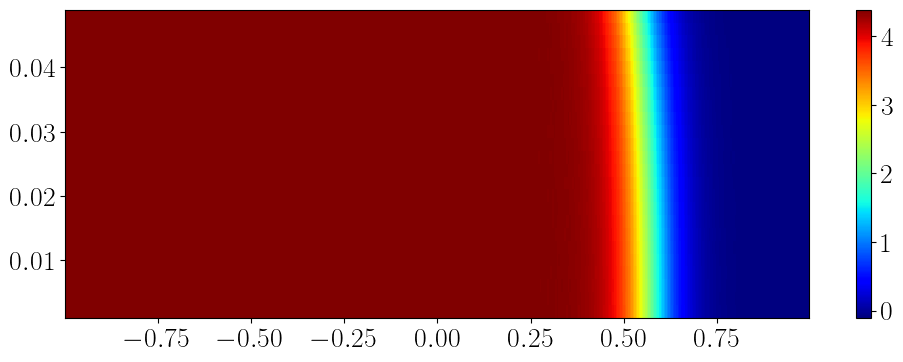

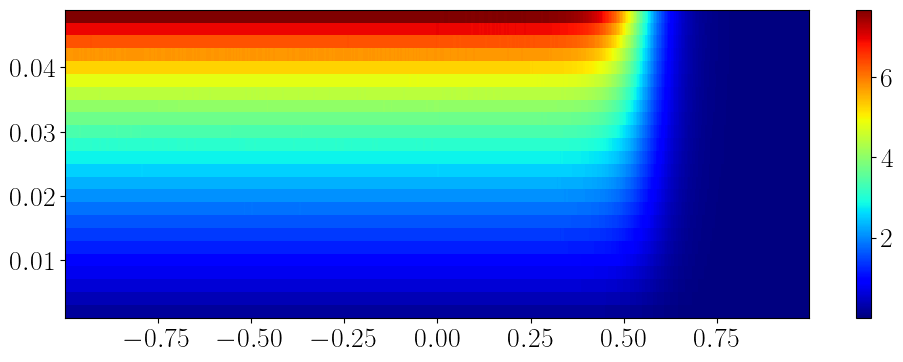

In [13]:
# plot DD ROM u and v
hr_str = '_col_hr' if ddnmrom.hr else ''
ct_str = '_srpc' if ddnmrom.constraint_type == 'strong' else '_wfpc'

x = np.linspace(x_lim[0], x_lim[1], nx+2)[1:-1]
y = np.linspace(y_lim[0], y_lim[1], ny+2)[1:-1]
X, Y = np.meshgrid(x, y)
U_rom = u_dd_rom.reshape(ny, nx)
V_rom = v_dd_rom.reshape(ny, nx)

plt.figure(figsize=(12,4))
plt.pcolormesh(X, Y, U_rom, cmap=cm.jet, shading='auto', vmin=u_fom.min(), vmax=u_fom.max())
# plt.xlabel('$x$')
# plt.ylabel('$y$')
cb = plt.colorbar()#label='$u(x, y)$')
file = nm_figs+f'u{ct_str}{hr_str}_state.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12,4))
plt.pcolormesh(X, Y, V_rom, cmap=cm.jet, shading='auto', vmin=v_fom.min(), vmax=v_fom.max())
# plt.xlabel('$x$')
# plt.ylabel('$y$')
cb = plt.colorbar()#label='$v(x, y)$')
file = nm_figs+f'v{ct_str}{hr_str}_state.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

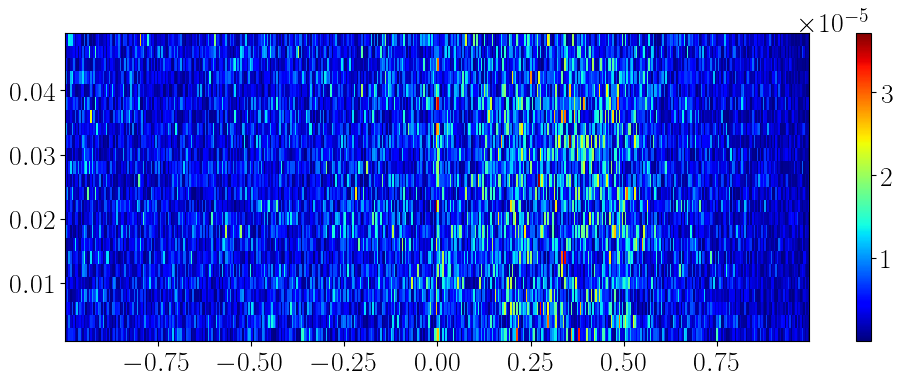

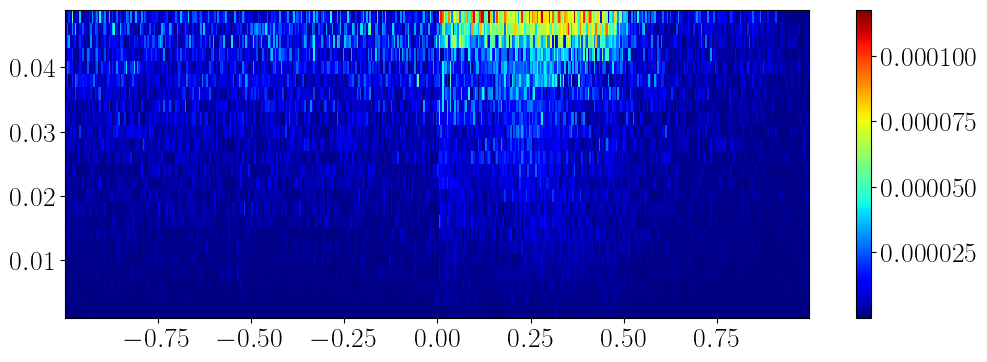

In [14]:
# plot errors
u_rel_err = np.abs(U_fom-U_rom)/np.linalg.norm(U_fom)
plt.figure(figsize=(12,4))
plt.pcolormesh(X, Y, u_rel_err, cmap=cm.jet, shading='auto')#, vmin=0.0, vmax=4.88e-4)
# plt.xlabel('$x$')
# plt.ylabel('$y$')
cb = plt.colorbar()#label='$u$ Relative error')
file = nm_figs+f'u{ct_str}{hr_str}_rel_error.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12,4))
v_rel_err = np.abs(V_fom-V_rom)/np.linalg.norm(V_fom)
plt.pcolormesh(X, Y, v_rel_err, cmap=cm.jet, shading='auto')#, vmin=0.0, vmax=4.88e-4)
# plt.xlabel('$x$')
# plt.ylabel('$y$')
cb = plt.colorbar()#label='$v$ Relative error')
file = nm_figs+f'v{ct_str}{hr_str}_rel_error.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [15]:
# Check constraints
# FOM
cres_fp= np.zeros(ddmdl.n_constraints)
for i, s in enumerate(ddmdl.subdomain):
    cres_fp += s.constraint_mat@ddnmrom.subdomain[i].de_intf(w_intf[i])[0]

# ROM
cres_rp = np.zeros(ddnmrom.n_constraints)
if ddnmrom.constraint_type == 'strong':
    for i, s in enumerate(ddnmrom.subdomain):
        cres_rp += s.constraint_mat@w_intf[i]
    print(f'ROM-port constraint residual (SRPC) = {np.linalg.norm(cres_rp):1.4e}')
    print(f'FOM-port constraint residual (SRPC) = {np.linalg.norm(cres_fp):1.4e}')
else:
    for i, s in enumerate(ddnmrom.subdomain):
        cres_rp += s.constraint_mat@s.de_intf(w_intf[i])[0]
    print(f'ROM-port constraint residual (WFPC) = {np.linalg.norm(cres_rp):1.4e}')
    print(f'FOM-port constraint residual (WFPC)= {np.linalg.norm(cres_fp):1.4e}')

ROM-port constraint residual (SRPC) = 0.0000e+00
FOM-port constraint residual (SRPC) = 0.0000e+00


In [16]:
# compute lagrange multiplier approximation
de, jde = ddnmrom.subdomain[0].de_intf(w_intf[0])
en, jen = ddnmrom.subdomain[0].en_intf(de)
lam_rom_approx = jen.T@lam_opt if ddnmrom.constraint_type=='strong' else ddnmrom.constraint_mult.T@lam_opt

# compute error estimate
xtilde = []
xhat = []
for i, s in enumerate(ddnmrom.subdomain):
    xtilde.append(s.de_intr(w_intr[i])[0])
    xtilde.append(s.de_intf(w_intf[i])[0])
    xhat.append(w_intr[i])
    xhat.append(w_intf[i])
    
xtilde.append(lam_rom_approx)
xtilde = np.concatenate(xtilde)
xhat.append(lam_opt)
xhat = np.concatenate(xhat)

f, j, rt = ddmdl.FJac(xtilde)
e = np.linalg.norm(sp.linalg.spsolve(j, f))

print(f'norm of FOM lagrange mult. = {np.linalg.norm(lam_fom):1.4e}')
print(f'norm of ROM lagrange mult. = {np.linalg.norm(lam_rom_approx):1.4e}')
print(f'Lagrange mult. error       = {np.linalg.norm(lam_fom-lam_rom_approx):1.4e}')
print(f"||(F'(g(x))^(-1)F(g(x)||   = {np.linalg.norm(e):1.4e}")

norm of FOM lagrange mult. = 2.2880e-25
norm of ROM lagrange mult. = 1.3069e+01
Lagrange mult. error       = 1.3069e+01
||(F'(g(x))^(-1)F(g(x)||   = 1.3086e+01


In [17]:
xstar = []
for i, s in enumerate(ddmdl.subdomain):
    xstar.append(u_intr[i])
    xstar.append(v_intr[i])    
    xstar.append(u_intf[i])
    xstar.append(v_intf[i]) 
xstar.append(lam_fom)
xstar = np.concatenate(xstar)

f, j, rt = ddmdl.FJac(xstar)
np.linalg.norm(sp.linalg.spsolve(j, f))

3.1714593546095404e-13

## Training time, number of parameters per subdomain

In [ ]:
print('subdomain       interior          interface')
for i, s in enumerate(ddnmrom.subdomain):
    print(f'    {i}          {s.train_time_intr:1.4e}         {s.train_time_intr:1.4e}')

In [ ]:
intr_params = []
intf_params = []
print('subdomain     interior     interface')
for i, s in enumerate(ddnmrom.subdomain):
    pcount = s.en_W1_intr.nnz+np.prod(s.en_W2_intr.shape)+s.en_b1_intr.size
    pcount += s.de_W2_intr.nnz+np.prod(s.de_W1_intr.shape)+s.de_b1_intr.size
    intr_params.append(pcount)
    
    pcount = s.en_W1_intf.nnz+np.prod(s.en_W2_intf.shape)+s.en_b1_intf.size
    pcount += s.de_W2_intf.nnz+np.prod(s.de_W1_intf.shape)+s.de_b1_intf.size
    intf_params.append(pcount)
    print(f'    {i}          {intr_params[i]}         {intf_params[i]}')

In [ ]:
maxp_per_subdomain=np.max(np.array(intr_params+intf_params))
all_params=np.sum(np.array(intr_params+intf_params))
all_params

In [ ]:
maxp_per_subdomain

In [ ]:
max_train_time = np.max([s.train_time_intr for s in ddnmrom.subdomain]+\
                        [s.train_time_intf for s in ddnmrom.subdomain])
max_train_time

In [ ]:
intr_params+intf_params

## Spy plots of sparsity masks

In [ ]:
# plot sparsity masks
sub = 0
plt.figure(figsize=(12, 4))
plt.spy(ddnmrom.subdomain[sub].de_mask_intr)
file = fig_dir+f'ld_{ddnmrom.subdomain[sub].intr_latent_dim}_rnnz_{intr_rnnz}_rshift_{intr_shift}_intr_mask.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 8))
plt.spy(ddnmrom.subdomain[sub].de_mask_intf)
plt.xticks([])
plt.yticks([])
file = fig_dir+f'ld_{ddnmrom.subdomain[sub].intf_latent_dim}'+ \
               f'_rnnz_{port_rnnz[0]}_rshift_{port_shift[0]}_intf_mask{ct_str}.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Check reconstruction error

In [ ]:
error = 0.0
intr_errors = []
intf_errors = []

for i, s in enumerate(ddnmrom.subdomain):
    uv_intr = np.concatenate([u_intr[i], v_intr[i]])
    uv_intf = np.concatenate([u_intf[i], v_intf[i]])
    
    num_intr = np.sum(np.square(uv_intr - s.de_intr(s.en_intr(uv_intr))[0])) 
    num_intf = np.sum(np.square(uv_intf - s.de_intf(s.en_intf(uv_intf))[0])) 
    den_intr = np.sum(np.square(uv_intr)) 
    den_intf =  np.sum(np.square(uv_intf)) 
    intr_errors.append(num_intr/den_intr)
    intf_errors.append(num_intf/den_intf)
    error += (num_intr+num_intf)/(den_intr+den_intf)
    
error = np.sqrt(error/ddnmrom.n_sub)
print(f'Relative reconstruction error = {error:1.4e}\n')
print('Subdomain     Intr. rel. error     Intf. rel. error')
for i in range(n_sub):
    print(f'    {i+1:2d}           {intr_errors[i]:1.4e}           {intf_errors[i]:1.4e}') 

## Analyze behavior of residual at FOM and ROM solutions

In [ ]:
# compute ROM residual, equality constraint
Ag_rom = np.zeros(ddnmrom.n_constraints)
res_rom = 0.0
res_list = []
for j, s in enumerate(ddnmrom.subdomain):
    res, jac, H, rhs, Ag, Adg = s.res_jac(w_intr[j], w_intf[j], lam_opt)
    res_list.append(res)
    res_rom += np.dot(res, res)
    Ag_rom += Ag
res_rom *= 0.5

# compute FOM residual, equality constraint
Ag_fom  = np.zeros(ddmdl.n_constraints)
res_fom = 0.0
for j, s in enumerate(ddmdl.subdomain):
    res_fom += np.linalg.norm(s.res_jac(u_intr[j], v_intr[j], u_intf[j], v_intf[j], lam_fom)[0])**2
    Ag_fom += s.constraint_mat@np.concatenate([u_intf[j], v_intf[j]])
res_fom *= 0.5

print(f'ROM LSTSQ residual  = {res_rom:1.4e}')
print(f'ROM constraint norm = {np.linalg.norm(Ag_rom):1.4e}')
print(f'FOM LSTSQ residual  = {res_fom:1.4e}')
print(f'FOM constraint norm = {np.linalg.norm(Ag_fom):1.4e}')

In [ ]:
# compute residual, constraint at encoded FOM solution 
Ag_en = np.zeros(ddnmrom.n_constraints)
res_en = 0.0
en_res_list = []
for j, s in enumerate(ddnmrom.subdomain):
    en_uv_intr = s.en_intr(np.concatenate((u_intr[j], v_intr[j])))
    en_uv_intf = s.en_intf(np.concatenate((u_intf[j], v_intf[j])))
    
    res, jac, H, rhs, Ag, Adg = s.res_jac(en_uv_intr, en_uv_intf, lam_opt)
    en_res_list.append(res)
    res_en += np.dot(res, res)
    Ag_en += Ag
res_en *= 0.5
print(f'ROM LSTSQ residual at encoded FOM sol.  = {res_en:1.4e}')
print(f'ROM constraint norm at encoded FOM sol. = {np.linalg.norm(Ag_en):1.4e}')

In [ ]:
x_err_list = []
res_fom_list = []
res_enc_list = []
RTr_fom_list = []
RTr_enc_list = []
for j, s in enumerate(ddmdl.subdomain):
    res, jac, H, rhs, Ax = s.res_jac(u_intr[j], v_intr[j], u_intf[j], v_intf[j], lam_fom)
    RTr = jac.T@res #np.concatenate([jac_intr.T@res, jac_intf.T@res])
    RTr_fom_list.append(np.linalg.norm(RTr))
    res_fom_list.append(np.linalg.norm(res))
    
    uv_intr_enc = np.concatenate((u_intr[j], v_intr[j]))
    uv_intf_enc = np.concatenate((u_intf[j], v_intf[j]))
    
    uv_intr_enc = ddnmrom.subdomain[j].de_intr(ddnmrom.subdomain[j].en_intr(uv_intr_enc))[0]
    uv_intf_enc = ddnmrom.subdomain[j].de_intf(ddnmrom.subdomain[j].en_intf(uv_intf_enc))[0]
    
    u_intr_enc = uv_intr_enc[:s.n_interior]
    v_intr_enc = uv_intr_enc[s.n_interior:] 
    u_intf_enc = uv_intf_enc[:s.n_interface]
    v_intf_enc = uv_intf_enc[s.n_interface:]
    
    res, jac, H, rhs, Ax = s.res_jac(u_intr_enc, v_intr_enc, u_intf_enc, v_intf_enc, lam_fom)
    RTr = jac.T@res #np.concatenate([jac_intr.T@res, jac_intf.T@res])
    RTr_enc_list.append(np.linalg.norm(RTr))
    res_enc_list.append(np.linalg.norm(res))
    
    x_err_list.append(np.linalg.norm(np.concatenate([u_intr[j], v_intr[j], u_intf[j], v_intf[j]])-
                                    np.concatenate([uv_intr_enc, uv_intf_enc])))
    
print(f"sub.     ||x-x_enc|||    ||r(x)||      ||r(x_enc)||     ||R'(x)^Tr(x)||    ||R'(x_enc)^Tr(x_enc)||")
for j in range(n_sub):
    print(f' {j:d}       {x_err_list[j]:1.3e}       {res_fom_list[j]:1.3e}     {res_enc_list[j]:1.3e}         {RTr_fom_list[j]:1.3e}         {RTr_enc_list[j]:1.3e}')    

In [ ]:
print(f"itr     ||R'*r||         ||Ag||")
for j, r in enumerate(rhs_vecs):
    Rr = np.linalg.norm(r[:-ddnmrom.n_constraints])
    Ag = np.linalg.norm(r[-ddnmrom.n_constraints:])    
    print(f' {j:2d}     {Rr:1.6e}     {Ag:1.6e}')

In [ ]:
# plot residuals on FD grid
nx_sub, ny_sub = nx//n_sub_x, ny//n_sub_y
nxy_sub = nx_sub*ny_sub
if ddnmrom.hr:
    u_res_list = []
    v_res_list = []
    for i, s in enumerate(ddnmrom.subdomain):
        r = np.zeros(2*s.n_residual)+1e-16
        r[s.hr_ind] = res_list[i]
        u_res_list.append(r[:nxy_sub].reshape(ny_sub, nx_sub))
        v_res_list.append(r[nxy_sub:].reshape(ny_sub, nx_sub))
else:
    u_res_list = [r[:nxy_sub].reshape(ny_sub, nx_sub) for r in res_list]
    v_res_list = [r[nxy_sub:].reshape(ny_sub, nx_sub) for r in res_list]

Ures = []
Vres = []
counter = 0
for j in range(n_sub_y):
    Urow = []
    Vrow = []
    for i in range(n_sub_x):
        sub = n_sub_x*j+i
        Urow.append(u_res_list[sub])
        Vrow.append(v_res_list[sub])
    Ures.append(Urow)
    Vres.append(Vrow)
Ures = np.abs(np.bmat(Ures))
Vres = np.abs(np.bmat(Vres))        

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, Ures, norm=colors.LogNorm(vmin=Ures.min(), vmax=Ures.max()), cmap=cm.jet)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar(label='$u$ residual')
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, Vres, norm=colors.LogNorm(vmin=Vres.min(), vmax=Vres.max()), cmap=cm.jet)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar(label='$v$ residual')
plt.show()

In [ ]:
# net_folder1 = './trained_nets/nx_480_ny_24_mu_0.1_2x_by_2y/'
# net_name = 'ld_10_rnnz_10_rshift_10_Sigmoid_batch_32_AbsMSEloss_4200snaps.p'
# filename = net_folder1 + 'sub_1of4/interior/' + net_name
# net_dict = torch.load(filename)
# de_net = net_dict['decoder']
# de_net

In [ ]:
# if 'net.2.bias' in de_net:
#     print('Deleting old NNs...')
#     for phase in ['interior', 'interface']:
#         for sub in range(n_sub):
#             os.remove(net_folder1+f'sub_{sub+1}of{n_sub}/{phase}/'+net_name)
#     print('All done!')
# else:
#     print('all good')

In [ ]:
w_opt = np.array([])
for i in range(ddnmrom.n_sub):
    w_opt = np.concatenate([w_opt, w_intr[i], w_intf[i]])
w_opt = np.concatenate([w_opt, lam_opt])

eig_list = []
for vec in [np.zeros(w0.shape), w_rbf, w_opt]:
    rhs, KKT, rjtime = ddnmrom.FJac(vec)
    eigs = la.eigh(KKT.toarray(), eigvals_only = True)
    eig_list.append(eigs/eigs.max())
    
plt.figure(figsize=(10, 8))
plt.scatter(np.arange(eig_list[0].size), eig_list[0], s=100, c='blue', marker='o', label='zeros', alpha=0.75)
plt.scatter(np.arange(eig_list[0].size), eig_list[1], s=100, c='red', marker='^', label='RBF initial', alpha=0.75)
plt.scatter(np.arange(eig_list[0].size), eig_list[2], s=100, c='green', marker='x', label='Final', alpha=0.75)
plt.yscale('log')
# plt.xscale('log')
plt.ylabel('Normalized Eigenvalues')
plt.xlabel('$k$')
plt.grid()
plt.legend()
plt.show()

print(f'# DoF = {ndof_rom}')
print(f'# constraints = {ddnmrom.n_constraints}\n')
print('          Zeros     RBF      Final')
print(f'# Pos.      {np.sum(eig_list[0]>0):2d}       {np.sum(eig_list[1]>0):2d}        {np.sum(eig_list[2]>0):2d}')
print(f'# Neg.      {np.sum(eig_list[0]<0):2d}       {np.sum(eig_list[1]<0):2d}        {np.sum(eig_list[2]<0):2d}')

In [ ]:
a = {}

In [ ]:
a[1]='b'

In [ ]:
a